In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

## Анализ и прогнозирование цен на внедорожники

Данные о продажах внедорожных автомобилей с пробегом на основании данных портала auto.ru за апрель 2020 г.
Объём общей выборки — 106 элементов; объёмы частных выборок по маркам — от 20 до 22 элементов.

- `cost` — цена
- `year` — год выпуска
- `mileage` — пробег
- `engine` – объём двигателя
- `model` — марка автомобиля

In [2]:
df = pd.read_csv('~/Downloads/auto.txt', sep='\t', index_col=0, 
                           names=['cost', 'year', 'mileage', 'engine', 'model'])

In [3]:
df.describe()

,cost,year,mileage,engine
count,106.000000,106.000000,106.000000,106.000000
mean,1382.566038,2009.745283,149.330189,3.460377
std,1076.342148,5.480809,84.711131,1.206149
min,210.000000,1990.000000,10.000000,2.000000
25%,700.500000,2008.000000,97.500000,2.425000
50%,1099.500000,2011.000000,135.000000,3.000000
75%,1515.000000,2014.000000,191.500000,4.500000
max,5250.000000,2019.000000,475.000000,5.600000


1. На основании частных выборок построим модель множественной регрессии
2. Оценим значимость уравнения регрессии и входящих в него коэффициентов
3. Оценим достоверность расчётов на основе значения коэффициента детерминации $R^2$
4. Оценим величины коэффициентов корреляции факторов модели и объясняемой переменной, а также коэффициентов корреляции между факторами
5. Сделаем выводы о возможных путях повышения качества модели, формируя при этом развернутые характеристики учасвтвующих в модели факторов и анализируя их связи с объясняемой переменной, а также возможные связи между собой.

Для правильной интерпретации коэффициентов МНК-модели нужно, чтобы данные удовлетворяли ряду требований:
- нормальность – значения зависимой переменной нормально распределены при фиксированных значениях независимых переменных;
- независимость – значения $Y_i$ независимы друг от друга;
- линейность – зависимая переменная линейно связана с независимыми;
- гомоскедастичность – дисперсия зависимой переменной постоянна при разных значениях независимых переменных. Можно назвать это свойство «однородностью дисперсии».

Если эти требования нарушаются, то тесты значимости и доверительные интервалы могут быть вычислены неточно.

In [4]:
df.pivot_table(columns='model',
                        values=['cost', 'year', 'mileage', 'engine'], 
                        aggfunc='mean', 
                        fill_value=0).T

,cost,engine,mileage,year
model,,,,
Jeep Cherokee,816.857143,3.000000,134.428571,2007.523810
Land Rover,1492.318182,2.954545,131.272727,2011.000000
Nissan Patrol,1146.600000,4.690000,169.950000,2009.300000
Subaru Forester,768.571429,2.238095,166.714286,2009.714286
Toyota Land Cruiser,2613.409091,4.454545,146.272727,2011.045455


In [6]:
mdf = pd.melt(df, id_vars=['model'], var_name=['var'])

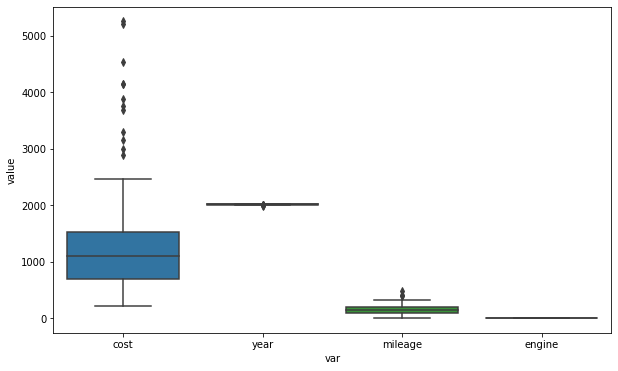

In [7]:
ax = sns.boxplot(x="var", y="value", data=mdf)

In [8]:
mdf # melted dataframe

,model,var,value
0,Nissan Patrol,cost,1250.0
1,Nissan Patrol,cost,1160.0
2,Nissan Patrol,cost,1100.0
3,Nissan Patrol,cost,879.0
4,Nissan Patrol,cost,1089.0
...,...,...,...
419,Subaru Forester,engine,2.0
420,Subaru Forester,engine,2.5
421,Subaru Forester,engine,2.0
422,Subaru Forester,engine,2.0


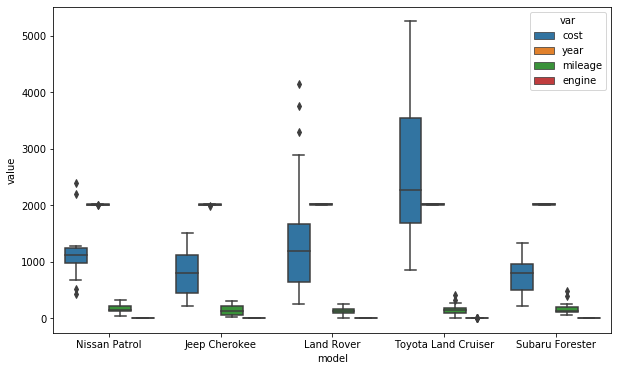

In [9]:
ax = sns.boxplot(x="model", y="value", hue='var', data=mdf)

### Выбросы на диаграме Кливленда

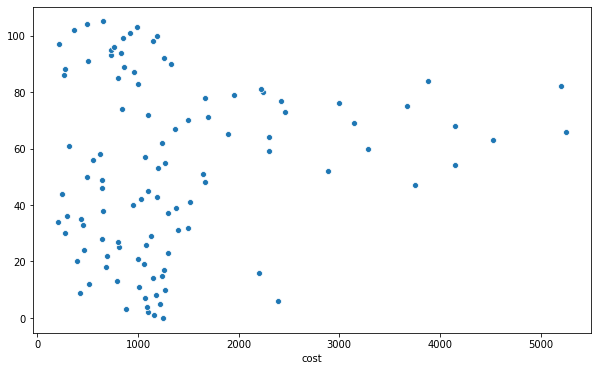

In [10]:
sns.scatterplot(df.cost, np.arange(len(df)));

Очевидные выбросы в распределении зависимой переменной наблюдаются за пределами 4,5 млн.

### Характер взаимосвязи зависимой переменной с предикторами

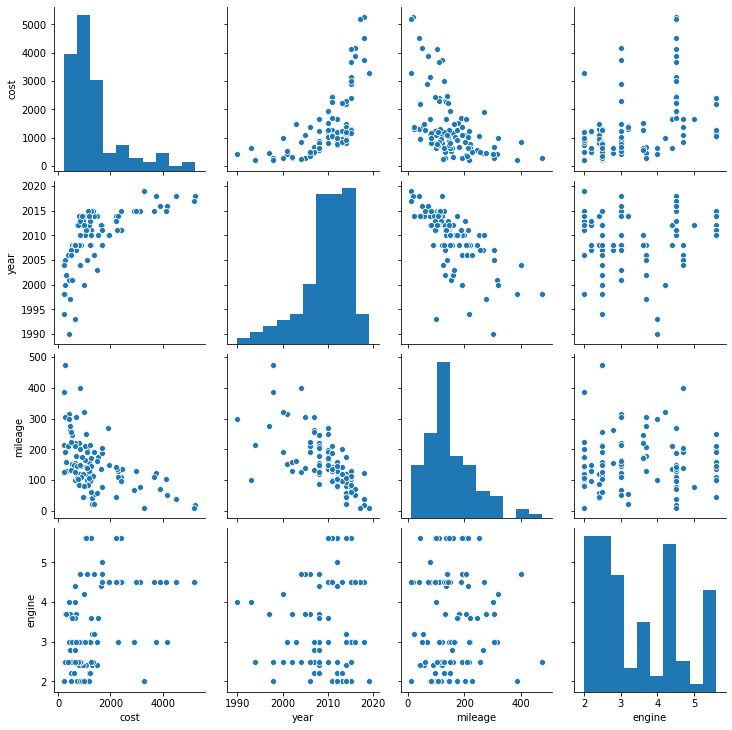

In [12]:
sns.pairplot(df);

In [4]:
from plotnine import * # ggplot

Заготовка в стилистике `R + ggplot2`

In [21]:
fig = (
    ggplot(df, aes(y='cost')) +
    geom_point(alpha=0.5) +
    geom_smooth(se=False, color='blue') +
    theme(figure_size=(8, 6))
)

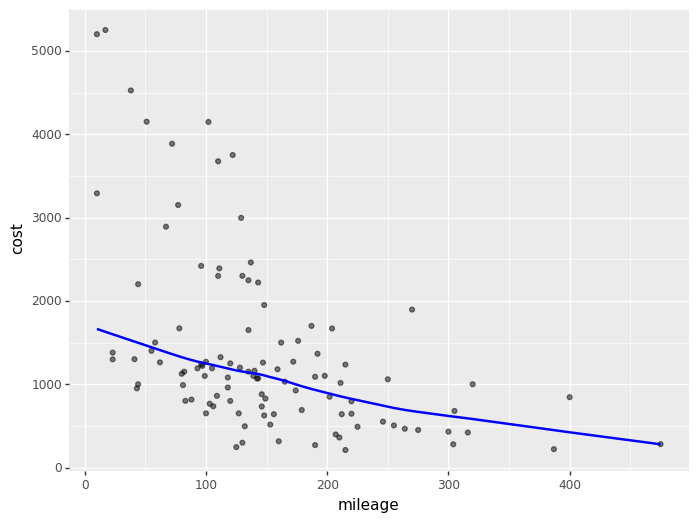

<ggplot: (7013754397)>

In [22]:
fig + aes(x='mileage') # взаимосвязь зависимой переменной cost с пробегом

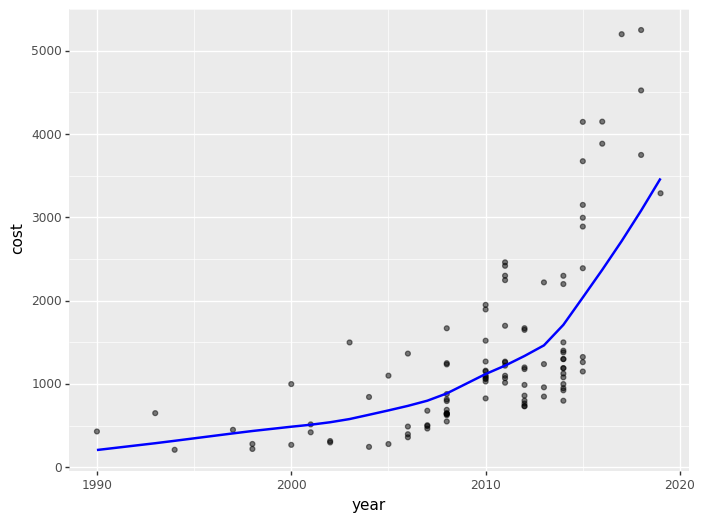

<ggplot: (7013945761)>

In [23]:
fig + aes(x='year') # взаимосвязь зависимой переменной cost с годом поизводства автомобиля

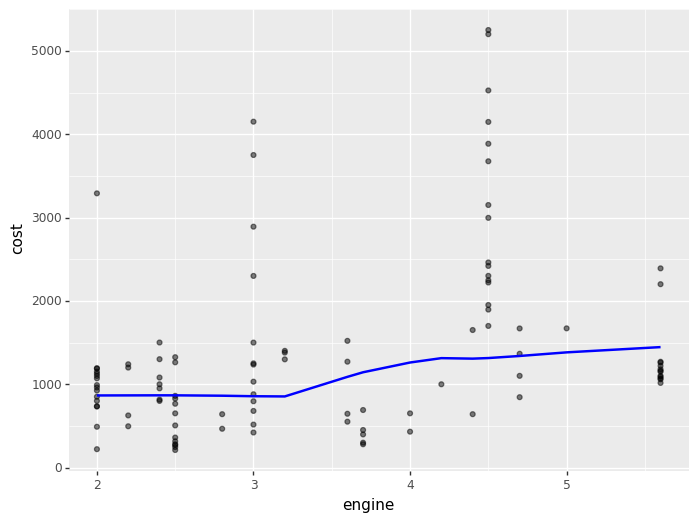

<ggplot: (7014144421)>

In [24]:
fig + aes(x='engine') # взаимосвязь зависимой переменной cost с объёмом двигателя

## Корреляция

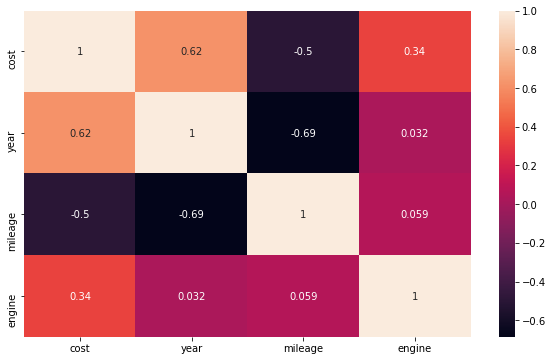

In [11]:
sns.heatmap(df.corr(), cbar=True, annot=True);

- Обычная корреляция не учитывает, что взаимосвязь между переменными может находиться под контролем других переменых и их взаимодействий.
- Множественные тесты. При тестировании значимости множества коэффициентов корреляции нужно вводить поправку для уровня значимости.

В корреляционной матрице можно наблюдать некоторую очевидную зависимость наблюдаемой переменной с предикторами `year` и `mileage`. Эти же переменные тесно связаны и друг с другом.

##  Множественная регрессионная модель для выборок

__Общий вид уравнения__

$y_i = b_0 + b_1x_{1i} + b_2x_{2i} + b3x_{3i} + e_i$

- $y_i$ – значение зависимой переменной для i-того наблюдения
- $b_0$ – свободный член (intercept)
- $b_1$ – частный угловой коэффициент для зависимости $y$ от $x_1$. Показывает, на сколько единиц изменяется y при изменении x1 на одну единицу, при условии, что все остальные предикторы не изменяются.
- $b_2, b_3$ – аналогично
- $e_i$ – варьирование $y$, не объясняемое данной моделью

### Апроксимируем модель множественной регрессии на наши данные

In [148]:
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from collections import defaultdict

Группируем данные по маркам автомобилей для исследования частных выборок 

In [40]:
group_models = df.groupby('model')

In [42]:
lin_reg = LinearRegression()

$\hat{y_1} = b_0 + b_1x_1 + b_2x_2 + b_2x_3 + e$



In [387]:
keys = group_models.groups.keys()
models = defaultdict(dict)

for key in keys:
    X = group_models.get_group(key).drop(['model', 'cost'], axis=1)
    y = group_models.get_group(key).cost.values
    lin_reg.fit(X, y)
    models[key]['coefs'] = np.array(lin_reg.coef_[1:])
    models[key]['predictions'] = lin_reg.predict(X)

In [120]:
for i, key in enumerate(keys):
    r2 = r2_score(group_models.get_group(key).cost, models[key]['predictions'])
    print(f'Model_{i} r2_score: {r2:.3f}')

Model_0 r2_score: 0.761
Model_1 r2_score: 0.793
Model_2 r2_score: 0.771
Model_3 r2_score: 0.839
Model_4 r2_score: 0.845


Коэффициент детерминации $R^2$ для всех выборок различается незначительно. Переменные модели способны описывать наши данные в границах 76-84%

Вспомним условия применимости линейных моделей
- Линейная связь
- Независимость наблюдений
- Нормальное распределение остатков
- Гомогенность дисперсий остатков
- Отсутствие коллинеарности предикторов (для множественной регрессии)

## Общая модель

In [281]:
#key = list(group_models.groups.keys())[4]
#dat = group_models.get_group(key)

In [343]:
fit = smf.ols('cost ~ year + mileage + engine', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     34.62
Date:                Wed, 03 Jun 2020   Prob (F-statistic):           1.63e-15
Time:                        00:03:22   Log-Likelihood:                -852.71
No. Observations:                 106   AIC:                             1713.
Df Residuals:                     102   BIC:                             1724.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.887e+05   3.81e+04     -4.955      0.0

Можно усомниться в значимости предиктора `mileage`. Остальные модель считает оказывающими влияние.

In [342]:
np.round(fit.params, 3)

Intercept    -158608.153
year              78.953
mileage           -3.217
engine           396.533
model_code       208.797
dtype: float64

#### Вид уравнения регрессии для всех данных

$$\hat{cost} = -188671.755 + 94.235 \times year -2.414 \times mileage + 296.722 \times engine$$

### Что делать, если мультиколлинеарность выявлена



Мы должны оценить, какую долю изменчивости конкретного предиктора могут объяснить другие предикторы (т.е. насколько предикторы связаны друг с другом).

### Фактор инфляции дисперсии (Variance inflation factor, VIF)

- Можно последовательно удалить из модели избыточные предикторы с VIF > 3 (иногда VIF > 2).
 1. подбираем модель
 2. считаем VIF
 3. удаляем предиктор с самым большим VIF
 4. повторяем 1-3, пока VIF не станет меньше 2
- Можно заменить исходные предикторы новыми независимыми друг от друга переменными, полученными с помощью метода главных компонент.

In [154]:
#cc = np.corrcoef(df.drop(['cost', 'model'], axis=1), rowvar=False)
#VIF = np.linalg.inv(cc)
#VIF.diagonal()

In [164]:
df_cor = df.drop('cost', axis=1).corr()
VIF = pd.Series(np.linalg.inv(df_cor.values).diagonal(), index=df_cor.index)
VIF

year       1.905380
mileage    1.910119
engine     1.013440
dtype: float64

Коэффициенты вздутия дисперсии для каждого из предикторов — в пределах нормы.

## Анализ остатков

### График расстояния Кука

Для выявления влятельных наблюдений

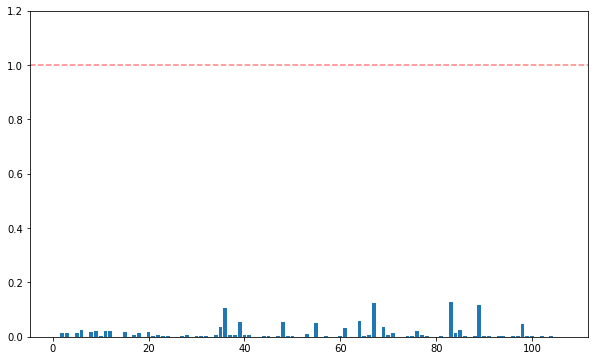

In [201]:
plt.ylim(0, 1.2)
plt.axhline(y=1, color='r', linestyle='--', alpha=.5)
plt.bar(range(1, len(df)+1), fit.get_influence().cooks_distance[0]);

Влиятельных наблюдений нет

### График зависимости предсказанных значений $\hat{y}$ и стьюдентезированных остатков

In [173]:
fit.get_influence().summary_frame()

,dfb_Intercept,dfb_year,dfb_mileage,dfb_engine,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
1,0.009246,-0.009181,-0.009277,-0.003612,0.000071,0.128202,0.016914,0.016816,0.127582,0.016735
1,0.009246,-0.009181,-0.009277,-0.003612,0.002089,-0.739981,0.015032,-0.091416,-0.738329,-0.091212
1,0.009246,-0.009181,-0.009277,-0.003612,0.000094,0.178446,0.011651,0.019375,0.177597,0.019282
1,0.009246,-0.009181,-0.009277,-0.003612,0.057957,2.372548,0.039556,0.481487,2.428860,0.492915
1,0.009246,-0.009181,-0.009277,-0.003612,0.003448,-0.688612,0.028266,-0.117445,-0.686827,-0.117141
...,...,...,...,...,...,...,...,...,...,...
21,-0.026872,0.026562,0.025137,0.031192,0.000974,-0.442770,0.019477,-0.062404,-0.441019,-0.062158
22,0.008357,-0.008613,0.005011,0.027519,0.000446,-0.269942,0.023919,-0.042257,-0.268712,-0.042064
22,0.008357,-0.008613,0.005011,0.027519,0.026207,1.871904,0.029047,0.323769,1.895549,0.327859
22,-0.116384,0.116409,-0.051160,0.159836,0.000446,-0.269942,0.023919,-0.042257,-0.268712,-0.042064


In [277]:
res_df = pd.DataFrame(
    {
        'fitted': fit.predict(), 
        'stdresid': fit.get_influence().resid_studentized_external
    }
)

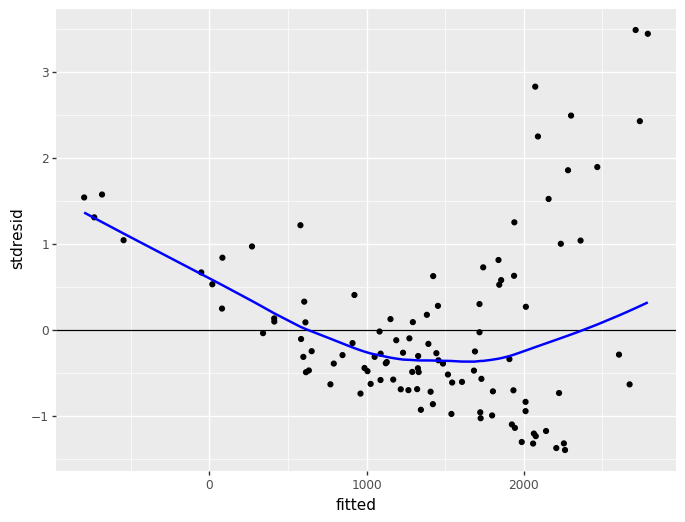

<ggplot: (7015567961)>

In [278]:
(   
    ggplot(res_df, aes(x='fitted', y='stdresid')) +
    geom_point() + geom_hline(yintercept = 0) + geom_smooth(se=False, color='blue') +
    theme(figure_size = (8, 6))
)

Выбросов нет. Гетерогенность дисперсии не выявляется.

### Распределение остатков на квантильном графике

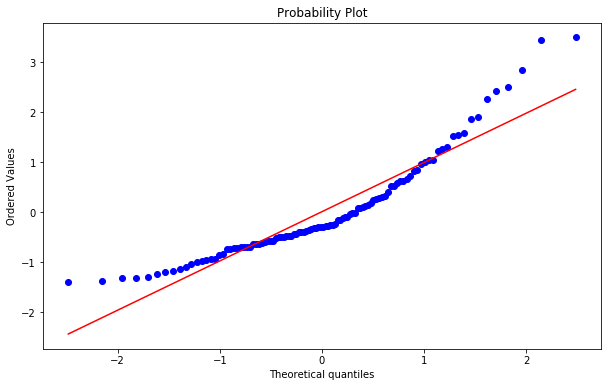

In [280]:
stats.probplot(fit.get_influence().resid_studentized_external, plot=sns.mpl.pyplot);

Отклонения от нормального распределения
остатков не выявляются.

### Какой из предикторов оказывает наиболее сильное влияние?

Для ответа на этот вопрос надо «уравнять» шкалы всех предикторов, то есть стандартизовать их.

Коэффициенты при стандартизованных предикторах покажут, насколько сильно меняется отклик при изменении предиктора на одно стандартное отклонение.

In [330]:
# df_scaled = df.drop('model', axis=1).apply(lambda x: x / (sum(x ** 2) ** 0.5) / (x.count() - 1), axis=0)

In [329]:
fit = smf.ols('cost ~ scale(year) + scale(mileage) + scale(engine)', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     34.62
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           1.63e-15
Time:                        22:47:24   Log-Likelihood:                -852.71
No. Observations:                 106   AIC:                             1713.
Df Residuals:                     102   BIC:                             1724.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1382.5660     74.664     18.

Уровень значимость переменной `scale(mileage)` в модели превышает допустимое значение 0.05, и её можно исключить из расчётов.

Коэффициент детерминации $R^2 = 0.505$ общей модели заметно снизился по сравнению с частными выборками по маркам.

In [344]:
#df['model_code'] = df.model.map(dict(zip(df.model.unique(), 
#                                         range(len(df.model.unique())))))

In [331]:
np.round(fit.params, 3)

Intercept         1382.566
scale(year)        514.041
scale(mileage)    -203.493
scale(engine)      356.199
dtype: float64

Сильнее всего со стоимостью автомобиля на вторичном рынке связан год выпуска авто и объём двигателя.
 - При изменении «свежести» авто на 1 SD цена увеличивается на 514.
 - При изменении объёма двигателя на 1 SD цена увеличивается на 356.

### Проблема оценки качества подгонки при большом количестве предикторов

Какая доля суммарной дисперсии зависимой переменной описывается данной моделью?

Чем больше предикторов, тем больше доля описанной дисперсии.

### Adjusted R-squared – скорректированный коэффициент детерминации

Применяется, если необходимо сравнить две модели с разным количеством параметров.

Вводится штраф за каждый новый параметр.

###  Итоговая  модель

In [418]:
fit = smf.ols('cost ~ year + engine', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     48.62
Date:                Wed, 03 Jun 2020   Prob (F-statistic):           1.35e-15
Time:                        00:37:08   Log-Likelihood:                -854.69
No. Observations:                 106   AIC:                             1715.
Df Residuals:                     103   BIC:                             1723.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.406e+05   2.79e+04     -8.623      0.0

In [347]:
np.round(fit.params, 3)

Intercept   -240572.861
year            119.904
engine          283.041
dtype: float64

$$\hat{cost} = -240572.861 + 119.904 \times year + 283.041 \times engine$$

### Предсказательная способность моделей

Оценим возможную стоимость автомобиля 2017 г. выпуска, с пробегом 50 тыс. км. и объёмом двигателя 4 л.

In [374]:
a = pd.DataFrame([2017, 50, 4.0], index=['year', 'mileage', 'engine']).T

In [375]:
fit.predict(a) # предсказание модели со всеми предикторами

0    2466.074761
dtype: float64

In [377]:
fit.predict(a) # предсказание модели без учета фактора «пробег»

0    2405.169281
dtype: float64

Предсказания обеих моделий приблизительно одинаковы.

Оценим точность расчетов по модели, оценив стоимость автомобиля Тойота Ленд Крузер 2016 г. выпуска с пробегом 72 тыс. км. и объёмом двигателя 4,5 литра (последний элемент частной выборки, стоимость 3885 тыс. руб.)

In [392]:
group_models.get_group('Toyota Land Cruiser').iloc[-1]

cost                         3885
year                         2016
mileage                        72
engine                        4.5
model         Toyota Land Cruiser
model_code                      3
Name: 22, dtype: object

In [416]:
b = group_models.get_group('Toyota Land Cruiser').iloc[[-1]]

#### Предсказание частной модели

In [390]:
models['Toyota Land Cruiser']['predictions'][-1]

3815.12168129551

#### Предсказание модели со всеми предикторами

In [417]:
fit.predict(b)

22    2467.101447
dtype: float64

#### Предсказание модели без учета фактора «пробег»

In [419]:
fit.predict(b)

22    2426.786155
dtype: float64

Все модели, кроме частной, показали низкую предсказательную способность. Этому могло послужить отсутствие факторов, описывающих брендовую составляющую, состояние автомобиля или каких-либо других предикторов, учавствующих в законе формирования стоимости внедорожников на вторичном рынке.